In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
import numpy as np

import strawberryfields as sf
from strawberryfields import ops
sf.about()

2022-06-27 17:39:52.736761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 17:39:52.736781: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



Strawberry Fields: a Python library for continuous-variable quantum circuits.
Copyright 2018-2020 Xanadu Quantum Technologies Inc.

Python version:            3.10.4
Platform info:             Linux-5.4.0-121-generic-x86_64-with-glibc2.31
Installation path:         /home/bartu/miniconda3/envs/qml/lib/python3.10/site-packages/strawberryfields
Strawberry Fields version: 0.23.0
Numpy version:             1.22.4
Scipy version:             1.8.1
SymPy version:             1.10.1
NetworkX version:          2.8.4
The Walrus version:        0.19.0
Blackbird version:         0.4.0
XCC version:               0.2.1
TensorFlow version:        2.9.1


In [2]:
latent_dim = 2

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Dense(3, activation ="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(4, activation="elu"),
      layers.Dense(3, activation="elu"),
      layers.Dense(latent_dim, activation="elu"),
    ])
    self.decoder = tf.keras.Sequential([
        layers.Dense(3, activation="elu"),
        layers.Dense(4, activation="elu"),
        layers.Dense(5, activation="elu"),
        layers.Dense(5, activation="elu"),
        layers.Dense(3, activation="elu")
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [3]:
# Number of modes
modes = 1

# Cutoff dimension (number of Fock states)
cutoff_dim = 3

# Number of layers (depth)
Qlayers = 25

# Number of steps in optimization routine performing gradient descent
reps = 50

# Learning rate
lr = 0.05

# Standard deviation of initial parameters
passive_sd = 0.2
active_sd = 0.01

# The gamma parameter in the penalty function, given by the reference paper.
norm_weight = 200

In [4]:
def init_weights(modes, layers, active_sd=0.0001, passive_sd=0.1):
    """Initialize a 2D TensorFlow Variable containing normally-distributed
    random weights for an ``N`` mode quantum neural network with ``L`` layers.

    Args:
        modes (int): the number of modes in the quantum neural network
        layers (int): the number of layers in the quantum neural network
        active_sd (float): the standard deviation used when initializing
            the normally-distributed weights for the active parameters
            (displacement, squeezing, and Kerr magnitude)
        passive_sd (float): the standard deviation used when initializing
            the normally-distributed weights for the passive parameters
            (beamsplitter angles and all gate phases)

    Returns:
        tf.Variable[tf.float32]: A TensorFlow Variable of shape
        ``[layers, 2*(max(1, modes-1) + modes**2 + modes)]``, where the Lth
        row represents the layer parameters for the Lth layer.
    """
    # Number of interferometer parameters:
    M = int(modes * (modes - 1)) + max(1, modes - 1)

    # Create the TensorFlow variables
    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    dp_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat(
        [int1_weights, s_weights, int2_weights, dr_weights, dp_weights, k_weights], axis=1
    )

    weights = tf.Variable(weights)

    return weights

In [5]:
# set the random seed
tf.random.set_seed(155)
np.random.seed(155)

In [6]:
autoencoder = Autoencoder(latent_dim)

2022-06-27 17:39:55.859179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-27 17:39:55.859204: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-27 17:39:55.859223: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BartuDesktop): /proc/driver/nvidia/version does not exist
2022-06-27 17:39:55.859461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def GenerateTargetState():
    return np.array([[0+0j, 1+0j, 0+0j]])
test_state = GenerateTargetState()
print(test_state)

[[0.+0.j 1.+0.j 0.+0.j]]


In [8]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

[0.+0.j 1.+0.j 0.+0.j]
Epoch 1/100
1/1 [==============================] - 1s 629ms/step - loss: 0.2235
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2151
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.2069
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1991
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1917
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1846
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1778
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1714
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1654
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1597
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1543
Epoch 12/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1493
Epoch 13/100
1/1 [==================

/tmp/ipykernel_39853/120199000.py:58: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Rep: 0 Cost: 1.0005 Fidelity: 0.0000 Trace: 0.0000
Rep: 1 Cost: 1.0013 Fidelity: 0.0000 Trace: 0.0000
Rep: 2 Cost: 1.0004 Fidelity: 0.0000 Trace: 0.0000
Rep: 3 Cost: 1.0005 Fidelity: 0.0000 Trace: 0.0000
Rep: 4 Cost: 1.0002 Fidelity: 0.0000 Trace: 0.0000
Rep: 5 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 6 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 7 Cost: 1.0001 Fidelity: 0.0000 Trace: 0.0000
Rep: 8 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 9 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 10 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 11 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 12 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 13 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 14 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 15 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 16 Cost: 0.9999 Fidelity: 0.0000 Trace: 0.0000
Rep: 17 Cost: 0.9999 Fidelity: 0.0000 Trace: 0.0000
Rep: 18 Cost: 0.9999 Fidelity: 0.0000 Trace: 0.0000
Rep: 19 Cost: 0.9999 F

1/1 [==============================] - 0s 4ms/step - loss: 3.0970e-06
Epoch 71/100
1/1 [==============================] - 0s 4ms/step - loss: 3.3218e-06
Epoch 72/100
1/1 [==============================] - 0s 4ms/step - loss: 4.5514e-06
Epoch 73/100
1/1 [==============================] - 0s 4ms/step - loss: 6.4157e-06
Epoch 74/100
1/1 [==============================] - 0s 4ms/step - loss: 8.5843e-06
Epoch 75/100
1/1 [==============================] - 0s 4ms/step - loss: 1.0778e-05
Epoch 76/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2784e-05
Epoch 77/100
1/1 [==============================] - 0s 4ms/step - loss: 1.4458e-05
Epoch 78/100
1/1 [==============================] - 0s 4ms/step - loss: 1.5720e-05
Epoch 79/100
1/1 [==============================] - 0s 4ms/step - loss: 1.6549e-05
Epoch 80/100
1/1 [==============================] - 0s 4ms/step - loss: 1.6972e-05
Epoch 81/100
1/1 [==============================] - 0s 4ms/step - loss: 1.7047e-05
Epoch 82/100
1/1 

/tmp/ipykernel_39853/120199000.py:58: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Rep: 0 Cost: 1.0709 Fidelity: 0.0019 Trace: 0.0057
Rep: 1 Cost: 1.0781 Fidelity: 0.0003 Trace: 0.0036
Rep: 2 Cost: 1.0407 Fidelity: 0.0007 Trace: 0.0029
Rep: 3 Cost: 1.0163 Fidelity: 0.0016 Trace: 0.0034
Rep: 4 Cost: 1.0088 Fidelity: 0.0020 Trace: 0.0034
Rep: 5 Cost: 1.0250 Fidelity: 0.0003 Trace: 0.0012
Rep: 6 Cost: 1.0248 Fidelity: 0.0003 Trace: 0.0008
Rep: 7 Cost: 1.0030 Fidelity: 0.0005 Trace: 0.0007
Rep: 8 Cost: 0.9881 Fidelity: 0.0007 Trace: 0.0008
Rep: 9 Cost: 0.9925 Fidelity: 0.0007 Trace: 0.0009
Rep: 10 Cost: 0.9959 Fidelity: 0.0007 Trace: 0.0008
Rep: 11 Cost: 0.9967 Fidelity: 0.0005 Trace: 0.0007
Rep: 12 Cost: 0.9967 Fidelity: 0.0004 Trace: 0.0005
Rep: 13 Cost: 0.9948 Fidelity: 0.0004 Trace: 0.0005
Rep: 14 Cost: 0.9898 Fidelity: 0.0004 Trace: 0.0005
Rep: 15 Cost: 0.9853 Fidelity: 0.0005 Trace: 0.0006
Rep: 16 Cost: 0.9823 Fidelity: 0.0007 Trace: 0.0007
Rep: 17 Cost: 0.9819 Fidelity: 0.0008 Trace: 0.0009
Rep: 18 Cost: 0.9811 Fidelity: 0.0010 Trace: 0.0011
Rep: 19 Cost: 0.9757 F

Rep: 157 Cost: 0.1413 Fidelity: 0.8473 Trace: 0.8477
Rep: 158 Cost: 0.2764 Fidelity: 0.8238 Trace: 0.8308
Rep: 159 Cost: 0.2337 Fidelity: 0.8090 Trace: 0.8205
Rep: 160 Cost: 0.3111 Fidelity: 0.8239 Trace: 0.8302
Rep: 161 Cost: 0.1297 Fidelity: 0.8557 Trace: 0.8572
Rep: 162 Cost: 0.2816 Fidelity: 0.8639 Trace: 0.8667
Rep: 163 Cost: 0.1671 Fidelity: 0.8418 Trace: 0.8454
Rep: 164 Cost: 0.3325 Fidelity: 0.8253 Trace: 0.8269
Rep: 165 Cost: 0.2325 Fidelity: 0.8292 Trace: 0.8304
Rep: 166 Cost: 0.2997 Fidelity: 0.8587 Trace: 0.8594
Rep: 167 Cost: 0.3448 Fidelity: 0.8643 Trace: 0.8665
Rep: 168 Cost: 0.1689 Fidelity: 0.8402 Trace: 0.8439
Rep: 169 Cost: 0.2175 Fidelity: 0.8425 Trace: 0.8445
Rep: 170 Cost: 0.2121 Fidelity: 0.8493 Trace: 0.8521
Rep: 171 Cost: 0.1358 Fidelity: 0.8516 Trace: 0.8533
Rep: 172 Cost: 0.2455 Fidelity: 0.8501 Trace: 0.8520
Rep: 173 Cost: 0.1222 Fidelity: 0.8490 Trace: 0.8508
Rep: 174 Cost: 0.1987 Fidelity: 0.8533 Trace: 0.8543
Rep: 175 Cost: 0.1355 Fidelity: 0.8530 Trace: 

1/1 [==============================] - 0s 3ms/step - loss: 0.0521
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0497
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0474
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0450
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0427
Epoch 12/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0405
Epoch 13/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0382
Epoch 14/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0359
Epoch 15/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0335
Epoch 16/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0312
Epoch 17/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0289
Epoch 18/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0266
Epoch 19/100
1/1 [==============================] - 0s 3ms/step - l

/tmp/ipykernel_39853/120199000.py:58: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Rep: 0 Cost: 1.0014 Fidelity: 0.0000 Trace: 0.0000
Rep: 1 Cost: 1.0018 Fidelity: 0.0000 Trace: 0.0000
Rep: 2 Cost: 1.0006 Fidelity: 0.0000 Trace: 0.0000
Rep: 3 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 4 Cost: 1.0011 Fidelity: 0.0000 Trace: 0.0000
Rep: 5 Cost: 1.0003 Fidelity: 0.0000 Trace: 0.0000
Rep: 6 Cost: 1.0004 Fidelity: 0.0000 Trace: 0.0000
Rep: 7 Cost: 1.0002 Fidelity: 0.0000 Trace: 0.0000
Rep: 8 Cost: 0.9997 Fidelity: 0.0000 Trace: 0.0000
Rep: 9 Cost: 0.9998 Fidelity: 0.0000 Trace: 0.0000
Rep: 10 Cost: 0.9998 Fidelity: 0.0000 Trace: 0.0000
Rep: 11 Cost: 0.9996 Fidelity: 0.0000 Trace: 0.0000
Rep: 12 Cost: 0.9992 Fidelity: 0.0000 Trace: 0.0000
Rep: 13 Cost: 0.9988 Fidelity: 0.0000 Trace: 0.0000
Rep: 14 Cost: 0.9982 Fidelity: 0.0000 Trace: 0.0000
Rep: 15 Cost: 0.9973 Fidelity: 0.0000 Trace: 0.0000
Rep: 16 Cost: 0.9967 Fidelity: 0.0000 Trace: 0.0000
Rep: 17 Cost: 0.9923 Fidelity: 0.0001 Trace: 0.0001
Rep: 18 Cost: 0.9853 Fidelity: 0.0003 Trace: 0.0003
Rep: 19 Cost: 0.9785 F

Rep: 157 Cost: 0.1904 Fidelity: 0.7377 Trace: 0.7385
Rep: 158 Cost: 0.2134 Fidelity: 0.7227 Trace: 0.7236
Rep: 159 Cost: 0.1963 Fidelity: 0.7266 Trace: 0.7274
Rep: 160 Cost: 0.2043 Fidelity: 0.7415 Trace: 0.7435
Rep: 161 Cost: 0.2236 Fidelity: 0.7352 Trace: 0.7385
Rep: 162 Cost: 0.2035 Fidelity: 0.7332 Trace: 0.7342
Rep: 163 Cost: 0.2166 Fidelity: 0.7247 Trace: 0.7259
Rep: 164 Cost: 0.1955 Fidelity: 0.7342 Trace: 0.7348
Rep: 165 Cost: 0.1950 Fidelity: 0.7413 Trace: 0.7425
Rep: 166 Cost: 0.1994 Fidelity: 0.7387 Trace: 0.7400
Rep: 167 Cost: 0.1787 Fidelity: 0.7302 Trace: 0.7304
Rep: 168 Cost: 0.1955 Fidelity: 0.7250 Trace: 0.7255
Rep: 169 Cost: 0.1938 Fidelity: 0.7413 Trace: 0.7421
Rep: 170 Cost: 0.1911 Fidelity: 0.7454 Trace: 0.7464
Rep: 171 Cost: 0.1802 Fidelity: 0.7379 Trace: 0.7381
Rep: 172 Cost: 0.1860 Fidelity: 0.7371 Trace: 0.7374
Rep: 173 Cost: 0.1853 Fidelity: 0.7432 Trace: 0.7438
Rep: 174 Cost: 0.1722 Fidelity: 0.7417 Trace: 0.7420
Rep: 175 Cost: 0.1768 Fidelity: 0.7428 Trace: 

1/1 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 9.4741e-04
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 8.6137e-04
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 7.7745e-04
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 6.9595e-04
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 6.1714e-04
Epoch 13/100
1/1 [==============================] - 0s 3ms/step - loss: 5.4145e-04
Epoch 14/100
1/1 [==============================] - 0s 3ms/step - loss: 4.6949e-04
Epoch 15/100
1/1 [==============================] - 0s 3ms/step - loss: 4.0199e-04
Epoch 16/100
1/1 [==============================] - 0s 3ms/step - loss: 3.3970e-04
Epoch 17/100
1/1 [==============================] - 0s 3ms/step - loss: 2.8321e-04
Epoch 18/100
1/1 [==============================] - 0s 4ms/step - loss: 2.3288e-04
Epoch 19/100
1/1 [=====

/tmp/ipykernel_39853/120199000.py:58: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Rep: 0 Cost: 1.0011 Fidelity: 0.0000 Trace: 0.0000
Rep: 1 Cost: 1.0024 Fidelity: 0.0000 Trace: 0.0000
Rep: 2 Cost: 1.0007 Fidelity: 0.0000 Trace: 0.0000
Rep: 3 Cost: 1.0004 Fidelity: 0.0000 Trace: 0.0000
Rep: 4 Cost: 1.0005 Fidelity: 0.0000 Trace: 0.0000
Rep: 5 Cost: 0.9999 Fidelity: 0.0000 Trace: 0.0000
Rep: 6 Cost: 0.9992 Fidelity: 0.0000 Trace: 0.0000
Rep: 7 Cost: 0.9996 Fidelity: 0.0000 Trace: 0.0000
Rep: 8 Cost: 0.9990 Fidelity: 0.0000 Trace: 0.0000
Rep: 9 Cost: 0.9987 Fidelity: 0.0000 Trace: 0.0000
Rep: 10 Cost: 0.9985 Fidelity: 0.0000 Trace: 0.0000
Rep: 11 Cost: 0.9967 Fidelity: 0.0000 Trace: 0.0000
Rep: 12 Cost: 0.9960 Fidelity: 0.0000 Trace: 0.0000
Rep: 13 Cost: 0.9927 Fidelity: 0.0001 Trace: 0.0001
Rep: 14 Cost: 0.9867 Fidelity: 0.0002 Trace: 0.0002
Rep: 15 Cost: 0.9775 Fidelity: 0.0006 Trace: 0.0006
Rep: 16 Cost: 0.9617 Fidelity: 0.0023 Trace: 0.0024
Rep: 17 Cost: 0.9301 Fidelity: 0.0066 Trace: 0.0066
Rep: 18 Cost: 0.9083 Fidelity: 0.0155 Trace: 0.0157
Rep: 19 Cost: 0.9207 F

Rep: 157 Cost: 0.1695 Fidelity: 0.7629 Trace: 0.7641
Rep: 158 Cost: 0.1661 Fidelity: 0.7685 Trace: 0.7695
Rep: 159 Cost: 0.1691 Fidelity: 0.7678 Trace: 0.7690
Rep: 160 Cost: 0.1745 Fidelity: 0.7639 Trace: 0.7648
Rep: 161 Cost: 0.1928 Fidelity: 0.7643 Trace: 0.7649
Rep: 162 Cost: 0.1614 Fidelity: 0.7700 Trace: 0.7702
Rep: 163 Cost: 0.1882 Fidelity: 0.7717 Trace: 0.7737
Rep: 164 Cost: 0.1790 Fidelity: 0.7722 Trace: 0.7737
Rep: 165 Cost: 0.1601 Fidelity: 0.7690 Trace: 0.7693
Rep: 166 Cost: 0.1608 Fidelity: 0.7700 Trace: 0.7704
Rep: 167 Cost: 0.1826 Fidelity: 0.7739 Trace: 0.7753
Rep: 168 Cost: 0.2115 Fidelity: 0.7750 Trace: 0.7764
Rep: 169 Cost: 0.1629 Fidelity: 0.7729 Trace: 0.7734
Rep: 170 Cost: 0.1724 Fidelity: 0.7661 Trace: 0.7673
Rep: 171 Cost: 0.1577 Fidelity: 0.7663 Trace: 0.7670
Rep: 172 Cost: 0.1579 Fidelity: 0.7720 Trace: 0.7727
Rep: 173 Cost: 0.1681 Fidelity: 0.7739 Trace: 0.7751
Rep: 174 Cost: 0.1489 Fidelity: 0.7725 Trace: 0.7729
Rep: 175 Cost: 0.1778 Fidelity: 0.7689 Trace: 

1/1 [==============================] - 0s 4ms/step - loss: 1.4052e-04
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 1.3774e-04
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 1.4064e-04
Epoch 10/100
1/1 [==============================] - 0s 4ms/step - loss: 1.4259e-04
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3888e-04
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 1.2775e-04
Epoch 13/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1029e-04
Epoch 14/100
1/1 [==============================] - 0s 5ms/step - loss: 8.9518e-05
Epoch 15/100
1/1 [==============================] - 0s 4ms/step - loss: 6.9057e-05
Epoch 16/100
1/1 [==============================] - 0s 3ms/step - loss: 5.1940e-05
Epoch 17/100
1/1 [==============================] - 0s 3ms/step - loss: 3.9791e-05
Epoch 18/100
1/1 [==============================] - 0s 3ms/step - loss: 3.2608e-05
Epoch 19/100
1/1 [=

/tmp/ipykernel_39853/120199000.py:58: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Rep: 0 Cost: 1.0012 Fidelity: 0.0000 Trace: 0.0000
Rep: 1 Cost: 1.0028 Fidelity: 0.0000 Trace: 0.0000
Rep: 2 Cost: 1.0009 Fidelity: 0.0000 Trace: 0.0000
Rep: 3 Cost: 1.0013 Fidelity: 0.0000 Trace: 0.0000
Rep: 4 Cost: 1.0008 Fidelity: 0.0000 Trace: 0.0000
Rep: 5 Cost: 1.0003 Fidelity: 0.0000 Trace: 0.0000
Rep: 6 Cost: 1.0003 Fidelity: 0.0000 Trace: 0.0000
Rep: 7 Cost: 1.0003 Fidelity: 0.0000 Trace: 0.0000
Rep: 8 Cost: 1.0001 Fidelity: 0.0000 Trace: 0.0000
Rep: 9 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 10 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 11 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 12 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 13 Cost: 1.0001 Fidelity: 0.0000 Trace: 0.0000
Rep: 14 Cost: 1.0001 Fidelity: 0.0000 Trace: 0.0000
Rep: 15 Cost: 1.0001 Fidelity: 0.0000 Trace: 0.0000
Rep: 16 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 17 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 18 Cost: 1.0000 Fidelity: 0.0000 Trace: 0.0000
Rep: 19 Cost: 1.0000 F

Rep: 157 Cost: 0.1914 Fidelity: 0.7551 Trace: 0.7570
Rep: 158 Cost: 0.2050 Fidelity: 0.7524 Trace: 0.7548
Rep: 159 Cost: 0.1990 Fidelity: 0.7465 Trace: 0.7471
Rep: 160 Cost: 0.2287 Fidelity: 0.7405 Trace: 0.7418
Rep: 161 Cost: 0.1978 Fidelity: 0.7439 Trace: 0.7451
Rep: 162 Cost: 0.1662 Fidelity: 0.7530 Trace: 0.7536
Rep: 163 Cost: 0.1707 Fidelity: 0.7576 Trace: 0.7585
Rep: 164 Cost: 0.1515 Fidelity: 0.7533 Trace: 0.7534
Rep: 165 Cost: 0.1861 Fidelity: 0.7409 Trace: 0.7416
Rep: 166 Cost: 0.1775 Fidelity: 0.7545 Trace: 0.7547
Rep: 167 Cost: 0.2346 Fidelity: 0.7481 Trace: 0.7491
Rep: 168 Cost: 0.1921 Fidelity: 0.7515 Trace: 0.7519
Rep: 169 Cost: 0.1729 Fidelity: 0.7511 Trace: 0.7518
Rep: 170 Cost: 0.1732 Fidelity: 0.7599 Trace: 0.7607
Rep: 171 Cost: 0.1923 Fidelity: 0.7687 Trace: 0.7695
Rep: 172 Cost: 0.2286 Fidelity: 0.7527 Trace: 0.7536
Rep: 173 Cost: 0.1788 Fidelity: 0.7483 Trace: 0.7486
Rep: 174 Cost: 0.1584 Fidelity: 0.7621 Trace: 0.7626
Rep: 175 Cost: 0.1958 Fidelity: 0.7684 Trace: 

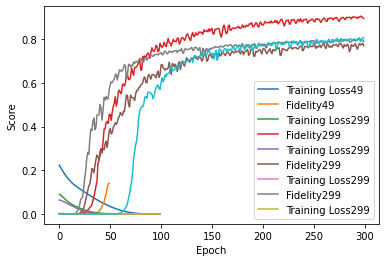

In [9]:
x_train = GenerateTargetState()

# defining desired state (single photon state)
target_state = x_train[0]
print(target_state)
##Below prevents Wigner state plotter check if it impacts representation
#target_state = tf.constant(target_state, dtype=tf.complex64)
classical_epochs = 100
for i in range(5):
    history = autoencoder.fit(x_train, x_train,
                    epochs=classical_epochs)
    
    encoded_st = autoencoder.encoder(np.array([target_state])).numpy()
    print(encoded_st)
    decoded_st = autoencoder.decoder(encoded_st).numpy()
    
    def layer(params, q):
        """CV quantum neural network layer acting on ``N`` modes.

        Args:
            params (list[float]): list of length ``2*(max(1, N-1) + N**2 + n)`` containing
                the number of parameters for the layer
            q (list[RegRef]): list of Strawberry Fields quantum registers the layer
                is to be applied to
        """
        ops.Dgate(tf.clip_by_value(encoded_st[0][0], clip_value_min = -1.5, clip_value_max = 1.5), encoded_st[0][1]) | q[0]

        N = len(q)
        M = int(N * (N - 1)) + max(1, N - 1)

        rphi = params[-N+1:]
        s = params[M:M+N]
        dr = params[2*M+N:2*M+2*N]
        dp = params[2*M+2*N:2*M+3*N]
        k = params[2*M+3*N:2*M+4*N]

        ops.Rgate(rphi[0]) | q[0]

        for i in range(N):
            ops.Sgate(s[i]) | q[i]

        ops.Rgate(rphi[0]) | q[0]

        for i in range(N):
            ops.Dgate(dr[i], dp[i]) | q[i]
            ops.Kgate(k[i]) | q[i]
    
    # initialize engine and program
    eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": cutoff_dim})
    qnn = sf.Program(modes)

    # initialize QNN weights
    weights = init_weights(modes, Qlayers) # our TensorFlow weights
    num_params = np.prod(weights.shape)   # total number of parameters in our model

    # Create array of Strawberry Fields symbolic gate arguments, matching
    # the size of the weights Variable.
    sf_params = np.arange(num_params).reshape(weights.shape).astype(np.str)
    sf_params = np.array([qnn.params(*i) for i in sf_params])


    # Construct the symbolic Strawberry Fields program by
    # looping and applying layers to the program.
    with qnn.context as q:
        for k in range(Qlayers):
            layer(sf_params[k], q)
            
    def cost(weights):
        # Create a dictionary mapping from the names of the Strawberry Fields
        # free parameters to the TensorFlow weight values.
        mapping = {p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))}

        # Run engine
        state = eng.run(qnn, args=mapping).state

        # Extract the statevector
        ket = state.ket()

        # Compute the fidelity between the output statevector
        # and the target state.
        fidelity = tf.abs(tf.reduce_sum(tf.math.conj(ket) * target_state)) ** 2

        # Objective function to minimize
        #cost = tf.abs(tf.reduce_sum(tf.math.conj(ket) * target_state) - 1)
        #return cost, fidelity, ket
        # Instead of the Cost function, maybe it is better to break it down to components
        # at least, when the Fock basis is insufficent, it will be visible
        difference = tf.reduce_sum(tf.abs(ket - target_state))
        fidelity = tf.abs(tf.reduce_sum(tf.math.conj(ket) * target_state)) ** 2
        return difference, fidelity, ket, tf.math.real(state.trace())
    
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    
    fid_progress = []
    best_fid = 0

    for i in range(reps):
        # reset the engine if it has already been executed
        if eng.run_progs:
            eng.reset()

        with tf.GradientTape() as tape:
            loss, fid, ket, trace = cost(weights)

        # Stores fidelity at each step
        fid_progress.append(fid.numpy())

        if fid > best_fid:
            # store the new best fidelity and best state
            best_fid = fid.numpy()
            learnt_state = ket.numpy()

        # one repetition of the optimization
        gradients = tape.gradient(loss, weights)
        opt.apply_gradients(zip([gradients], [weights]))
         # Prints progress at every rep
        if i % 1 == 0:
            print("Rep: {} Cost: {:.4f} Fidelity: {:.4f} Trace: {:.4f}".format(i, loss, fid, trace))
        
    plt.plot(history.history["loss"], label="Training Loss" + str(i))
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.legend()
    
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.sans-serif"] = ["Computer Modern Roman"]
    plt.style.use("default")

    plt.plot(fid_progress, label = "Fidelity" + str(i))
    plt.ylabel("Score")
    plt.xlabel("Epoch")

    x_train = np.array([learnt_state])
    
    reps = 300
    """
    classical_epochs = 20
    reps = 40
    """
print(learnt_state)
print(decoded_st)

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def wigner(rho):
    """This code is a modified version of the 'iterative' method
    of the wigner function provided in QuTiP, which is released
    under the BSD license, with the following copyright notice:

    Copyright (C) 2011 and later, P.D. Nation, J.R. Johansson,
    A.J.G. Pitchford, C. Granade, and A.L. Grimsmo.

    All rights reserved."""
    import copy

    # Domain parameter for Wigner function plots
    l = 5.0
    cutoff = rho.shape[0]

    # Creates 2D grid for Wigner function plots
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)

    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m) * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

In [11]:
rho_target = np.outer(target_state, target_state.conj())
rho_learnt = np.outer(learnt_state, learnt_state.conj())

/tmp/ipykernel_39853/2788124896.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


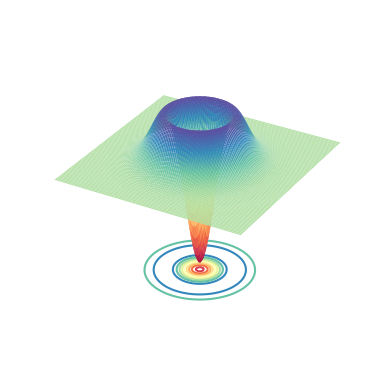

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_target)
ax.plot_surface(X, P, W, cmap="Spectral", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="Spectral", linestyles="solid", offset=-0.17)
ax.set_axis_off()
fig.show()

/tmp/ipykernel_39853/4222121820.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


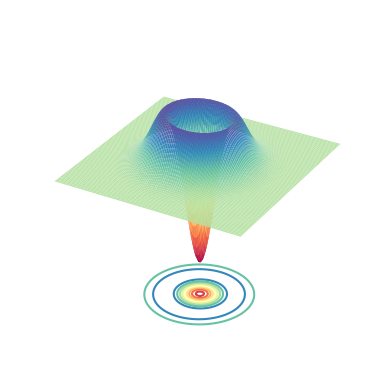

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_learnt)
ax.plot_surface(X, P, W, cmap="Spectral", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="Spectral", linestyles="solid", offset=-0.17)
ax.set_axis_off()
fig.show()